In [25]:
import os
import pandas as pd
import tensorflow as tf
#import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import logging

from joblib import dump, load
from datetime import timedelta
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import RegressorChain
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
import lightgbm as lightgbm

pd.options.display.max_rows = 10


logging.basicConfig(filename='output.log', level=logging.INFO, filemode='w')

completeTimer = time.time()
typeTimer = time.time()
estimatorTimer = time.time()


# environment
isSuperComputer = True

cantonKeys = ['AG','AI','AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VD', 'VS', 'ZG','ZH']

data = pd.read_csv("completedata.csv")

# last check if there are some NaN values in the data which we use
for col in data.columns:
    if data[col].isna().sum() != 0:
        print(col+" (#NaN/#NotNaN): (" + str(data[col].isna().sum())+"/"+str(data[col].notna().sum())+")")


numberOfInputWeeks = 3
numberOfOutputWeeks = 1
#display([col for col in data.columns])


outputCategories = [
                  'case_inz_entries_7dayAverage',
                  'hosp_inz_entries_7dayAverage',
                  'death_inz_entries_7dayAverage',
                  'testPositvity',
                  'testPositvity_7dayAverageBoth',    
                  'transit_stations_percent_change_from_baseline_7dayAverage',
                  'workplaces_percent_change_from_baseline_7dayAverage',    
                   ]
numberOfOutputs = len(outputCategories)
numberOfPreComputedOutputWeeks = 4

split = numberOfOutputs * numberOfPreComputedOutputWeeks + 2
train_features = data[data['category']=='train'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
train_labels = data[data['category']=='train'].iloc[:,-split:-2]
validation1_features = data[data['category']=='validation 1'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
validation1_labels = data[data['category']=='validation 1'].iloc[:,-split:-2]
validation2_features = data[data['category']=='validation 2'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
validation2_labels = data[data['category']=='validation 2'].iloc[:,-split:-2]

'''
cId = 'AI'
train_features = data[(data['category']=='train')].iloc[:,0:-26]
train_labels = data[(data['category']=='train')].iloc[:,-26:-2]
validation1_features = data[(data['category']=='validation 1') & (data['cantonId']==cId)].iloc[:,0:-26]
validation1_labels = data[(data['category']=='validation 1') & (data['cantonId']==cId)].iloc[:,-26:-2]
validation2_features = data[(data['category']=='validation 2') & (data['cantonId']==cId)].iloc[:,0:-26]
validation2_labels = data[(data['category']=='validation 2') & (data['cantonId']==cId)].iloc[:,-26:-2]
'''


#pip = Pipeline([('std_scaler', StandardScaler())])
pip = Pipeline([('minmax_scaler', MinMaxScaler())])

X_train = pip.fit_transform(train_features[train_features.columns].values)
X_valid1 = pip.transform(validation1_features[train_features.columns].values)
X_valid2 = pip.transform(validation2_features[train_features.columns].values)


In [26]:
modelId = 0
# (str(type(estimator)) == "<class 'tensorflow.python.keras.engine.functional.Functional'>")

results = pd.DataFrame(columns=['model',
                                'model type',
                                'target',
                                'week',
                                'model rsme 1', 
                                'model rsme 2'])
results.to_csv("results.csv", index=False)

# --------------------------------------------------------------------------------------------------------
'''
typeTimer = time.time()
logging.info("============== fitting normal sklearn estimators ============== ")

# fitting normal sklearn estimators

estimators = [
    linear_model.Ridge(alpha=1),
    linear_model.Lasso(alpha=1),
]


if isSuperComputer:
    # all all estimators which we want to search through
    estimators = []
    
    
    # add LGBMs & XGBoost
    for regalpha in [0.01,0,10]:
        for reglambda in [0.1,1]: #0.01,0,10
            estimators.append(lightgbm.LGBMRegressor(n_estimators=1000, reg_alpha=regalpha, reg_lambda=reglambda, n_jobs=-1))
            estimators.append(xgb.XGBRegressor(n_estimators=1000, reg_alpha=regalpha, reg_lambda=reglambda, n_jobs=-1))  
    
    for regalpha in [0.1,1]: #0.01,0,10
        for reglambda in [0.01,0,10]:
            estimators.append(lightgbm.LGBMRegressor(n_estimators=1000, reg_alpha=regalpha, reg_lambda=reglambda, n_jobs=-1))
            estimators.append(xgb.XGBRegressor(n_estimators=1000, reg_alpha=regalpha, reg_lambda=reglambda, n_jobs=-1)) 
    
    for regalpha in [0.1,1]: #0.01,0,10
        for reglambda in [0.1,1]: #0.01,0,10
            estimators.append(lightgbm.LGBMRegressor(n_estimators=1000, reg_alpha=regalpha, reg_lambda=reglambda, n_jobs=-1))
            estimators.append(xgb.XGBRegressor(n_estimators=1000, reg_alpha=regalpha, reg_lambda=reglambda, n_jobs=-1)) 
    
 
    # add random forrest  
    for nrOfEstimators in [100,200,500,1000]: 
        for maxdepth in [None, 2, 4]:
            for mss in [2,3,4]:
                for msl in [1,2,3]:
                    estimators.append(RandomForestRegressor(n_estimators=nrOfEstimators, 
                                                            max_depth=maxdepth, 
                                                            min_samples_split=mss, 
                                                            min_samples_leaf=msl,
                                                            n_jobs=-1))
  
    
    # add MLPs
    for alpha in [0.01,0.1]: #0.00001,0.0001,0.001
        for layer in [
            (20),
            (100),
            (20,20),
            (100,10),
            (100,50,10),
            (100,100,10),
        ]:
            estimators.append(MLPRegressor(hidden_layer_sizes=layer, alpha=alpha, max_iter=1000))
    
    # add SVRs
    for c in [0.001,0.1,10]: #0.01,1,100
        estimators.append(svm.SVR(C=c)) 
    

    
    # add linear models
    #estimators.append(linear_model.Ridge(alpha=0))
    #estimators.append(linear_model.Lasso(alpha=0)) 
    for alpha in [0.001,0.1,10]: #0.01,1,100
        estimators.append(linear_model.Ridge(alpha=alpha))
        estimators.append(linear_model.Lasso(alpha=alpha)) 
        for lr in ['invscaling']: #,'adaptive','optimal'
            for p in ['l1','l2']: #,'elasticnet'
                estimators.append(linear_model.SGDRegressor(learning_rate = lr,penalty=p, alpha=alpha,max_iter=10000, tol=0.00001, n_iter_no_change=10))
    
logging.info("number of estimators to fit: " + str(len(estimators)*len(outputCategories))+" ")


while len(estimators) > 0:
    estimator = estimators.pop(0)
    estimatorTimer = time.time()
    logging.info(str(estimator)+"")
    for category in outputCategories:
        logging.info("-- " + category+"")
        
        trainOutput = train_labels[["output_"+category+"_"+str(i) for i in range(0,numberOfOutputWeeks)]] 
        reg = estimator.fit(X_train, trainOutput.values)           
        # save the fitted regressor
        dump(reg, 'models/'+str(modelId)+'.joblib') 
        reg = load('models/'+str(modelId)+'.joblib') 
        modelId = modelId + 1
        
        predictions_valid1 = pd.DataFrame(reg.predict(X_valid1), index=validation1_labels.index, columns=["pred_week_" + str(i)+"_"+category for i in range(0,numberOfOutputWeeks)]) 
        predictions_valid2 = pd.DataFrame(reg.predict(X_valid2), index=validation2_labels.index, columns=["pred_week_" + str(i)+"_"+category for i in range(0,numberOfOutputWeeks)])
        
        valid1Output = validation1_labels[["output_"+category+"_"+str(i) for i in range(0,numberOfOutputWeeks)]]
        valid2Output = validation2_labels[["output_"+category+"_"+str(i) for i in range(0,numberOfOutputWeeks)]]
        
        for predictionWeek in range(0,numberOfOutputWeeks):
            rmse1 = np.sqrt(mean_squared_error(predictions_valid1["pred_week_" + str(predictionWeek)+"_"+category], valid1Output.iloc[:,predictionWeek]))
            rmse2 = np.sqrt(mean_squared_error(predictions_valid2["pred_week_" + str(predictionWeek)+"_"+category], valid2Output.iloc[:,predictionWeek]))
            
            d = {'model':[reg],'model type': ["sklearn_single_output"],'target':[category],'week':[predictionWeek], 'model rsme 1':[rmse1], 'model rsme 2':[rmse2]}
            df = pd.DataFrame(data=d)
            df.to_csv("results.csv",mode='a', header=False, index=False)
            
    logging.info(str(estimator)+" (%s) " % (time.time() - estimatorTimer))
            
logging.info("============== finished fitting normal sklearn estimators ============== (%s) " % (time.time() - typeTimer))           
'''
# ------------------------------------------------------------------------------------------------                       

typeTimer = time.time()
logging.info("============== fitting single output keras estimators ============== ")
start = time.time()
# fitting single output keras estimators

numberOfOutputsForMultiOutput = numberOfOutputWeeks * len(outputCategories)
epochs = 1000
batch_size = 16

def getNormalKerasModel(name, learningrate, nrOfNeurons, isMultiOutput):
    input_ = keras.layers.Input(shape=X_train.shape[1:])
    hidden1 = keras.layers.Dense(nrOfNeurons, activation="relu")(input_)
    output = keras.layers.Dense(numberOfOutputsForMultiOutput)(hidden1) if isMultiOutput else keras.layers.Dense(1)(hidden1)
    model = keras.Model(name=name, inputs=[input_],outputs=[output])
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learningrate))
    return model


def getDropoutKerasModel(name, learningrate, nrOfNeurons, isMultiOutput):
    input_ = keras.layers.Input(shape=X_train.shape[1:])
    hidden1 = keras.layers.Dense(nrOfNeurons, activation="relu")(input_)
    dropout1 = keras.layers.Dropout(rate=0.1)(hidden1)
    output = keras.layers.Dense(numberOfOutputsForMultiOutput)(dropout1) if isMultiOutput else keras.layers.Dense(1)(dropout1)
    model = keras.Model(name=name, inputs=[input_],outputs=[output])
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learningrate))
    return model

def getRegularizedKerasModel(name, learningrate, nrOfNeurons, alpha, isMultiOutput):
    input_ = keras.layers.Input(shape=X_train.shape[1:])
    hidden1 = keras.layers.Dense(nrOfNeurons, activation="relu", kernel_regularizer=keras.regularizers.l2(alpha))(input_)
    output = keras.layers.Dense(numberOfOutputsForMultiOutput)(hidden1) if isMultiOutput else keras.layers.Dense(1)(hidden1)
    model = keras.Model(name=name, inputs=[input_],outputs=[output])
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learningrate))
    return model

def getTwoWayKerasModel(name, learningrate, nrOfNeurons, isMultiOutput):
    input_ = keras.layers.Input(shape=X_train.shape[1:])
    hidden1 = keras.layers.Dense(nrOfNeurons, activation="relu")(input_)
    concat = keras.layers.Concatenate()([input_,hidden1])
    output = keras.layers.Dense(numberOfOutputsForMultiOutput)(concat) if isMultiOutput else keras.layers.Dense(1)(concat)
    model = keras.Model(name=name, inputs=[input_],outputs=[output])
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learningrate))
    return model

def getComplexKerasModel(name, learningrate, nrOfNeurons1, nrOfNeurons2, isMultiOutput):
    input_ = keras.layers.Input(shape=X_train.shape[1:])
    hidden1 = keras.layers.Dense(nrOfNeurons1, activation="relu")(input_)
    hidden2 = keras.layers.Dense(nrOfNeurons2, activation="relu")(hidden1)
    output = keras.layers.Dense(numberOfOutputsForMultiOutput)(hidden1) if isMultiOutput else keras.layers.Dense(1)(hidden2)
    model = keras.Model(name=name, inputs=[input_],outputs=[output])
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learningrate))
    return model

def getTwoWayComplexDropoutKerasModel(name, learningrate, nrOfNeurons1, nrOfNeurons2, nrOfNeurons3, nrOfNeurons4, nrOfNeurons5, isMultiOutput):
    input_ = keras.layers.Input(shape=X_train.shape[1:])
    hidden1 = keras.layers.Dense(nrOfNeurons1, activation="relu")(input_)
    dropout1 = keras.layers.Dropout(rate=0.5)(hidden1)
    hidden2 = keras.layers.Dense(nrOfNeurons2, activation="relu")(hidden1)
    dropout1 = keras.layers.Dropout(rate=0.5)(hidden2)
    hidden3 = keras.layers.Dense(nrOfNeurons3, activation="relu")(hidden2)
    dropout1 = keras.layers.Dropout(rate=0.5)(hidden3)
    hidden4 = keras.layers.Dense(nrOfNeurons4, activation="relu")(hidden3)
    dropout1 = keras.layers.Dropout(rate=0.5)(hidden4)
    hidden5 = keras.layers.Dense(nrOfNeurons5, activation="relu")(hidden4)
    dropout1 = keras.layers.Dropout(rate=0.5)(hidden5)
    concat = keras.layers.Concatenate()([input_,dropout1])
    output = keras.layers.Dense(numberOfOutputsForMultiOutput)(concat) if isMultiOutput else keras.layers.Dense(1)(concat)
    model = keras.Model(name=name, inputs=[input_],outputs=[output])
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learningrate))
    return model

'''  
estimators = []

estimators.append(getNormalKerasModel("simple", 0.0001, 10, False))

if isSuperComputer:
    # all all estimators which we want to search through
    estimators = []
    
    for learningrate in [0.001,0.0001,0.00001]:
        estimators.append(getNormalKerasModel("normal_learningrate_"+str(learningrate)+"_batchsize_"+str(batch_size), learningrate, 100, False))
        estimators.append(getDropoutKerasModel("dropout_learningrate_"+str(learningrate)+"_batchsize_"+str(batch_size), learningrate, 100, False))
        estimators.append(getTwoWayKerasModel("twoway_learningrate_"+str(learningrate)+"_batchsize_"+str(batch_size), learningrate, 100, False))
        estimators.append(getComplexKerasModel("complex_learningrate_"+str(learningrate)+"_batchsize_"+str(batch_size), learningrate, 100, 10, False))
        estimators.append(getTwoWayComplexDropoutKerasModel("twowaycomplexdropout_learningrate_"+str(learningrate)+"_batchsize_"+str(batch_size), learningrate, 200, 150, 100, 50, 10, False))
        
        for alpha in [0.01, 0.0001]: # 0.1, 0.001
            estimators.append(getRegularizedKerasModel("regularized_learningrate_"+str(learningrate)+"_alpha_"+str(alpha)+"_batchsize_"+str(batch_size), learningrate, 100, alpha, False))     
    
    

logging.info("number of estimators to fit: " + str(len(estimators)*len(outputCategories)))
 
while len(estimators) > 0:
    estimator = estimators.pop(0)
    estimatorTimer = time.time()
    
    logging.info(str(estimator.name))
    for category in outputCategories:
        
        logging.info("-- " + category)
        
        y_train = train_labels[["output_"+category+"_"+str(i) for i in range(0,numberOfOutputWeeks)]].values 
        y_valid1 = validation1_labels[["output_"+category+"_"+str(i) for i in range(0,numberOfOutputWeeks)]].values 
        estimator.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_valid1,y_valid1), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
        reg = estimator
      
        # save the fitted regressor
        reg.save('models/'+str(modelId))
        reg = keras.models.load_model('models/'+str(modelId))
        modelId = modelId + 1
        
        predictions_valid1 = pd.DataFrame(reg.predict(X_valid1), index=validation1_labels.index, columns=["pred_week_" + str(i)+"_"+category for i in range(0,numberOfOutputWeeks)]) 
        predictions_valid2 = pd.DataFrame(reg.predict(X_valid2), index=validation2_labels.index, columns=["pred_week_" + str(i)+"_"+category for i in range(0,numberOfOutputWeeks)])
        
        valid1Output = validation1_labels[["output_"+category+"_"+str(i) for i in range(0,numberOfOutputWeeks)]]
        valid2Output = validation2_labels[["output_"+category+"_"+str(i) for i in range(0,numberOfOutputWeeks)]]
        
        for predictionWeek in range(0,numberOfOutputWeeks):
            rmse1 = np.sqrt(mean_squared_error(predictions_valid1["pred_week_" + str(predictionWeek)+"_"+category], valid1Output.iloc[:,predictionWeek]))
            rmse2 = np.sqrt(mean_squared_error(predictions_valid2["pred_week_" + str(predictionWeek)+"_"+category], valid2Output.iloc[:,predictionWeek]))
            
            d = {'model':[reg.name],'model type': ["keras_single_output"],'target':[category],'week':[predictionWeek], 'model rsme 1':[rmse1], 'model rsme 2':[rmse2]}
            df = pd.DataFrame(data=d)
            df.to_csv("results.csv",mode='a', header=False, index=False)

    logging.info(str(estimator.name)+" (%s)" % (time.time() - estimatorTimer))
         
logging.info("============== finished fitting single output keras estimators ============== (%s) " % (time.time() - typeTimer))   
''' 
# ----------------------------------------------------------------------------------------------------

typeTimer = time.time()
logging.info("============== fitting multi output keras estimators ============== ")

estimators = []

estimators.append(getNormalKerasModel("simple", 0.0001, 10, True))

if isSuperComputer:
    # all all estimators which we want to search through
    estimators = []
    
    for learningrate in [0.001,0.0001,0.00001]:
        estimators.append(getNormalKerasModel("normal_learningrate_"+str(learningrate), learningrate, 100, True))
        estimators.append(getDropoutKerasModel("dropout_learningrate_"+str(learningrate), learningrate, 100, True))
        estimators.append(getTwoWayKerasModel("twoway_learningrate_"+str(learningrate), learningrate, 100, True))
        estimators.append(getComplexKerasModel("complex_learningrate_"+str(learningrate), learningrate, 100, 10, True))
        estimators.append(getTwoWayComplexDropoutKerasModel("twowaycomplexdropout_learningrate_"+str(learningrate)+"_batchsize_"+str(batch_size), learningrate, 200, 150, 100, 50, 10, True))
        
        for alpha in [0.01, 0.001, 0.0001]: #0.1
            estimators.append(getRegularizedKerasModel("regularized_learningrate_"+str(learningrate)+"_alpha_"+str(alpha)+"_batchsize_"+str(batch_size), learningrate, 100, alpha, True))     


logging.info("number of estimators to fit: " + str(len(estimators)))

start = time.time()

while len(estimators) > 0:
    estimator = estimators.pop(0)
    estimatorTimer = time.time()
    logging.info(str(estimator.name))
    logging.info("-- all categories")
    
    
    y_train = train_labels[["output_"+category+"_"+str(i) for category in outputCategories for i in range(0,numberOfOutputWeeks)]].values
    y_valid1 = validation1_labels[["output_"+category+"_"+str(i) for category in outputCategories for i in range(0,numberOfOutputWeeks)]].values 
    estimator.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_valid1,y_valid1), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
    reg = estimator
    
    # save the fitted regressor
    reg.save('models/'+str(modelId))
    reg = keras.models.load_model('models/'+str(modelId))
    modelId = modelId + 1
    
    predictions_valid1 = pd.DataFrame(reg.predict(X_valid1), index=validation1_labels.index, columns=["pred_week_" + str(i)+"_"+category for category in outputCategories for i in range(0,numberOfOutputWeeks)]) 
    predictions_valid2 = pd.DataFrame(reg.predict(X_valid2), index=validation2_labels.index, columns=["pred_week_" + str(i)+"_"+category for category in outputCategories for i in range(0,numberOfOutputWeeks)])
    
    valid1Output = validation1_labels[["output_"+category+"_"+str(i) for category in outputCategories for i in range(0,numberOfOutputWeeks)]]
    valid2Output = validation2_labels[["output_"+category+"_"+str(i) for category in outputCategories for i in range(0,numberOfOutputWeeks)]]

    for predictionWeek in range(0,numberOfOutputWeeks):
        for category in outputCategories:
            rmse1 = np.sqrt(mean_squared_error(predictions_valid1["pred_week_" + str(predictionWeek)+"_"+category], valid1Output["output_"+category+"_"+str(predictionWeek)]))
            rmse2 = np.sqrt(mean_squared_error(predictions_valid2["pred_week_" + str(predictionWeek)+"_"+category], valid2Output["output_"+category+"_"+str(predictionWeek)]))
            
            d = {'model':[reg.name],'model type': ["keras_multi_output"],'target':[category],'week':[predictionWeek], 'model rsme 1':[rmse1], 'model rsme 2':[rmse2]}
            df = pd.DataFrame(data=d)
            df.to_csv("results.csv",mode='a', header=False, index=False)
            
    logging.info(str(estimator.name)+" (%s)" % (time.time() - estimatorTimer))

logging.info("============== finished fitting multi output keras estimators ============== (%s) " % (time.time() - typeTimer))

# ----------------------------------------------------------------------------------------------------
typeTimer = time.time()

logging.info("============== fitting multioutput sklearn estimators ============== ")
# fitting multioutput sklearn estimators
estimators = [
    linear_model.MultiTaskLasso(),
]
if isSuperComputer:
    # all all estimators which we want to search through
       
    estimators = []
    
    '''
    kernels = ['linear','poly','polynomial','rbf','laplacian','sigmoid','cosine']
    for alpha in [0.01,0.1,10]:
        for k in kernels:
            estimators.append(KernelRidge(kernel=k, alpha=alpha))
    '''
    
    for nrOfEstimators in [100,200,500]: #100
        for maxdepth in [None, 2, 4]:
            for mss in [2,3,4]:
                for msl in [1,2,3]:
                    estimators.append(RandomForestRegressor(n_estimators=nrOfEstimators, 
                                                            max_depth=maxdepth, 
                                                            min_samples_split=mss, 
                                                            min_samples_leaf=msl,
                                                            n_jobs=-1))
    '''
    for alpha in [100]: #0.001,0.01,0.1,1,10,
        for layer in [
            (20),
            (100),
            (20,20),
            (100,10),
            (100,50,10),
            (100,100,10),
        ]:
            estimators.append(MLPRegressor(hidden_layer_sizes=layer, alpha=alpha, max_iter=1000))
    
    
    for alpha in [10, 1, 0.1,0.01]: #0.00001, 0.0001,0.001
        estimators.append(linear_model.MultiTaskLasso(alpha=alpha))
    
    for alpha in [0.0001, 0.00001]: # 0.001,0.01,0.1,1,10,100
        estimators.append(linear_model.Lasso(alpha=alpha))
        estimators.append(linear_model.Ridge(alpha=alpha))
    '''
    
logging.info("number of estimators to fit: " + str(len(estimators))+" ")

while len(estimators) > 0:
    estimator = estimators.pop(0)
    estimatorTimer = time.time()
    logging.info(str(estimator))
    logging.info("-- all categories")
    
    
    trainOutput = train_labels[["output_"+category+"_"+str(i) for category in outputCategories for i in range(0,numberOfOutputWeeks)]]
    reg = estimator.fit(X_train, trainOutput.values)
    # save the fitted regressor
    dump(reg, 'models/'+str(modelId)+'.joblib') 
    reg = load('models/'+str(modelId)+'.joblib') 
    modelId = modelId + 1
    
    predictions_valid1 = pd.DataFrame(reg.predict(X_valid1), index=validation1_labels.index, columns=["pred_week_" + str(i)+"_"+category for category in outputCategories for i in range(0,numberOfOutputWeeks)]) 
    predictions_valid2 = pd.DataFrame(reg.predict(X_valid2), index=validation2_labels.index, columns=["pred_week_" + str(i)+"_"+category for category in outputCategories for i in range(0,numberOfOutputWeeks)])
    
    valid1Output = validation1_labels[["output_"+category+"_"+str(i) for category in outputCategories for i in range(0,numberOfOutputWeeks)]]
    valid2Output = validation2_labels[["output_"+category+"_"+str(i) for category in outputCategories for i in range(0,numberOfOutputWeeks)]]

    
    for predictionWeek in range(0,numberOfOutputWeeks):
        for category in outputCategories:
            rmse1 = np.sqrt(mean_squared_error(predictions_valid1["pred_week_" + str(predictionWeek)+"_"+category], valid1Output["output_"+category+"_"+str(predictionWeek)]))
            rmse2 = np.sqrt(mean_squared_error(predictions_valid2["pred_week_" + str(predictionWeek)+"_"+category], valid2Output["output_"+category+"_"+str(predictionWeek)]))
            
            d = {'model':[reg],'model type': ["sklearn_multi_output"],'target':[category],'week':[predictionWeek], 'model rsme 1':[rmse1], 'model rsme 2':[rmse2]}
            df = pd.DataFrame(data=d)
            df.to_csv("results.csv",mode='a', header=False, index=False)
        
    logging.info(str(estimator)+" (%s) " % (time.time() - estimatorTimer))
       
logging.info("============== finished fitting multioutput sklearn estimators ============== (%s) " % (time.time() - typeTimer))

# -----------------------------------------------------------------------------------------------------


logging.info("============== finished ============== %s " % (time.time() - completeTimer))

INFO:tensorflow:Assets written to: models/14/assets
INFO:tensorflow:Assets written to: models/15/assets
INFO:tensorflow:Assets written to: models/16/assets
INFO:tensorflow:Assets written to: models/17/assets
INFO:tensorflow:Assets written to: models/18/assets
INFO:tensorflow:Assets written to: models/19/assets
INFO:tensorflow:Assets written to: models/20/assets
INFO:tensorflow:Assets written to: models/21/assets


'Best estimator in each category vs. baseline'

,model,model type,target,week,model rsme 1,model rsme 2,last value baseline rsme 1,last value baseline rsme 2,diff to last value baseline 1
0,"MultiTaskLasso(alpha=0.001, copy_X=True, fit_i...",sklearn_multi_output,case_inz_entries_7dayAverage,0,1.699098,3.045040,3.196178,15.651428,0.468397
372,"LGBMRegressor(boosting_type='gbdt', class_weig...",sklearn_single_output,death_inz_entries_7dayAverage,0,0.071333,0.134511,0.157100,0.287626,0.545937
744,"Lasso(alpha=0.001, copy_X=True, fit_intercept=...",sklearn_single_output,hosp_inz_entries_7dayAverage,0,0.155770,0.264319,0.374793,0.595523,0.584385
1116,"MLPRegressor(activation='relu', alpha=0.01, ba...",sklearn_single_output,testPositvity,0,0.029124,0.049954,0.032502,0.069910,0.103926
1487,"Lasso(alpha=0.001, copy_X=True, fit_intercept=...",sklearn_single_output,testPositvity_7dayAverageBoth,0,0.008597,0.025248,0.009519,0.035338,0.096888
1858,"Lasso(alpha=0.1, copy_X=True, fit_intercept=Tr...",sklearn_single_output,transit_stations_percent_change_from_baseline_...,0,4.234254,6.082493,5.260542,8.727526,0.195092
2229,"MLPRegressor(activation='relu', alpha=1e-05, b...",sklearn_single_output,workplaces_percent_change_from_baseline_7dayAv...,0,2.737400,3.398233,4.534230,9.822916,0.396281


'Randomforest comparison'

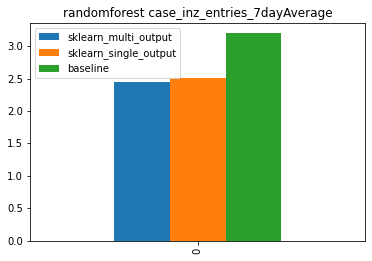

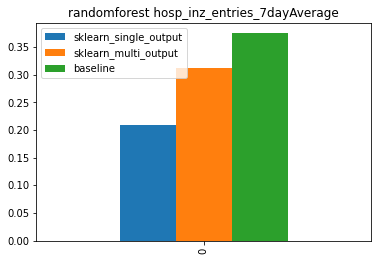

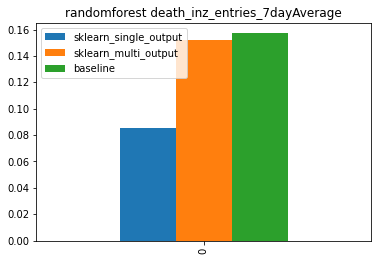

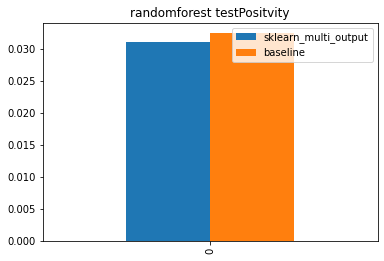

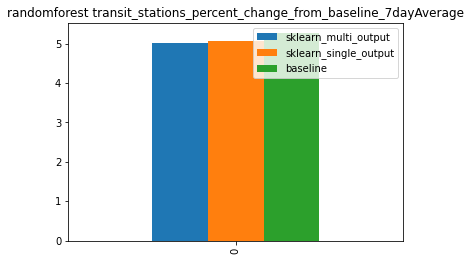

In [157]:

pd.options.display.max_rows = None
results = pd.read_csv("results_1.csv")
results = results.append(pd.read_csv("results_2.csv"), ignore_index=True)
results = results.append(pd.read_csv("results_3.csv"), ignore_index=True)
results = results.append(pd.read_csv("results_4.csv"), ignore_index=True)
results = results.append(pd.read_csv("results_5.csv"), ignore_index=True)
results = results.append(pd.read_csv("results_6.csv"), ignore_index=True)
# attach the baseline values
for predictionWeek in range(0,numberOfOutputWeeks):
    for category in outputCategories:
        # last value of last input week
        last_value_baseline_rmse1 = np.sqrt(mean_squared_error(validation1_features[category+"_last_"+str(numberOfInputWeeks-1)],
                                                               validation1_labels["output_"+category+"_"+str(predictionWeek)]))
        last_value_baseline_rmse2 = np.sqrt(mean_squared_error(validation2_features[category+"_last_"+str(numberOfInputWeeks-1)],
                                                               validation2_labels["output_"+category+"_"+str(predictionWeek)]))
        
        estimatorRows = results[(results['week']==predictionWeek) & (results['target']==category)]

        results.loc[estimatorRows.index, 'last value baseline rsme 1'] = last_value_baseline_rmse1
        results.loc[estimatorRows.index, 'last value baseline rsme 2'] = last_value_baseline_rmse2

      
results['diff to last value baseline 1'] = (results['last value baseline rsme 1']-results['model rsme 1'])/results['last value baseline rsme 1']
results = results.sort_values(['diff to last value baseline 1'], ascending=False)




# plot the best estimators for every category
df1 = results.groupby(['target']).apply(lambda x: x.sort_values(["diff to last value baseline 1"], ascending=False)).reset_index(drop=True)
df2 = df1.groupby('target').head(1)
#df2 = df2.set_index('model')
display("Best estimator in each category vs. baseline")
display(df2)
'''
df2.plot(title='Best estimator in each category vs. baseline',
         kind='bar', 
         x=['target','target','target','target','target','target','target'], 
         xticks = [-1,2,4,0.2,5,7],
         y='diff to last value baseline 1', 
         ylabel='diff to last value baseline 1', 
         use_index=False)
'''

display("Randomforest comparison")
for category in outputCategories: 
    df1 = results[(results['target']==category) & 
            (results['diff to last value baseline 1'] >= 0) &
            (results['model'].str.contains("RandomForest"))]
    df1.groupby(['model type']).apply(lambda x: x.sort_values(["diff to last value baseline 1"], ascending=False)).reset_index(drop=True)
    df2 = df1.groupby('model type').head(1) #[['model type','model rsme 1']]   
    
    if df2.shape[0] > 0:
        baselinersme = df2['last value baseline rsme 1'].values[0]
        df2 = df2[['model type','model rsme 1']]
        df3 = pd.DataFrame(df2[['model rsme 1']].transpose())
        df3.columns = df2['model type'].values
        df3[['baseline']] = baselinersme
        df3.plot(kind='bar', title="randomforest " + category, use_index=False)
    
    #& # learningrate , Random, LGBM, XGB (results['model type'].str.contains("multi_output"))
  


In [117]:
# inspect a regressor
identifier = 1718

import sys

sys.stdout.write(results.loc[[identifier]]['model'].values[0])







RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=2000, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
'''
for cantonId in cantonKeys:
    category = regressors[identifier][1]
    dfForPlot = regressors[identifier][2] 

    d = dfForPlot[dfForPlot['cantonId']==cantonId]
    d = d.drop(['cantonId'], axis=1).rolling(window=7).mean()
    d.plot(kind='line',figsize=(20,10), title=cantonId)
    plt.show()

    d = d[d[category+"_"+str(numberOfInputWeeks-1)].notna()]


    sns.set_theme(style="ticks", palette="pastel",rc={"figure.figsize":(20, 10)})
    sns.boxplot(palette=["m", "g", 'r'], data=d).set(title=cantonId)
    plt.show()
'''

In [ ]:
'''
# if the regressor has a features importance attribute
df = pd.DataFrame(regressors[identifier][0].estimators_[week].feature_importances_.transpose(), 
                  index=train_features[inputDict[regressors[identifier][1]]].columns, 
                  columns=['importance']).sort_values(['importance'], 
                  ascending=False)
df.plot(kind='barh', y='importance', figsize=(10,200))
plt.show()


# if the regressor has coefficients attribute 
df = pd.DataFrame(regressors[identifier][0].estimators_[week].coef_.transpose(), 
                  index=train_features[inputDict[regressors[identifier][1]]].columns, 
                  columns=['coefficients']).sort_values(['coefficients'], 
                  ascending=False)
df.plot(kind='barh', y='coefficients', figsize=(10,200))
plt.show()
'''